This jupyter notebook tries to predict solar flares in the next day based on the last N days using recurrent neural networks (NN) for binary (flare or not) classification.
It is divided in 4 parts:
* Loading libraries and data.
* Transforming the dataset and doing some feature engineering.
* Making and fiting the model.
* Checking the results.

# Forecasting solar flares using neural networks for classification
***


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score, 
                             fbeta_score, recall_score)

from sklearn.preprocessing import StandardScaler

from keras import Input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Load raw dataframe
df = pd.read_csv("../data/data_flares.csv")

print(df.info())
print(df.shape)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DATE                        4480 non-null   object 
 1   USFLUX                      4480 non-null   float64
 2   MEANGAM                     4480 non-null   float64
 3   MEANGBT                     4480 non-null   float64
 4   MEANGBZ                     4480 non-null   float64
 5   MEANGBH                     4480 non-null   float64
 6   MEANJZD                     4480 non-null   float64
 7   TOTUSJZ                     4480 non-null   float64
 8   MEANALP                     4480 non-null   float64
 9   MEANJZH                     4480 non-null   float64
 10  TOTUSJH                     4480 non-null   float64
 11  ABSNJZH                     4480 non-null   float64
 12  SAVNCPP                     4480 non-null   float64
 13  MEANPOT                     4480 

# Changing the dataframe to fit NN
***

In [3]:
# Ensure the 'DATE' column is in datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   DATE                        4480 non-null   datetime64[ns, UTC]
 1   USFLUX                      4480 non-null   float64            
 2   MEANGAM                     4480 non-null   float64            
 3   MEANGBT                     4480 non-null   float64            
 4   MEANGBZ                     4480 non-null   float64            
 5   MEANGBH                     4480 non-null   float64            
 6   MEANJZD                     4480 non-null   float64            
 7   TOTUSJZ                     4480 non-null   float64            
 8   MEANALP                     4480 non-null   float64            
 9   MEANJZH                     4480 non-null   float64            
 10  TOTUSJH                     4480 non-null   float64         

In [4]:
# Analyze flare distribution over time
# Number of flare-days per year
df_flares = df.groupby(df['DATE'].dt.year)['flare_today'].agg(['sum'])
print(df_flares)

        sum
DATE       
2010    8.0
2011   65.0
2012   79.0
2013   68.0
2014  118.0
2015   68.0
2016   11.0
2017   15.0
2018    0.0
2019    0.0
2020    2.0
2021   21.0
2022   92.0
2023    8.0


In [5]:
# Number of days with flares (count should be 365 or 366 for leap years)
yearly_flares = df.groupby(df['DATE'].dt.year)['flare_today'].agg(['sum', 'count'])
print("\nDays with flare distribution by year:")
print(yearly_flares)


Days with flare distribution by year:
        sum  count
DATE              
2010    8.0    245
2011   65.0    365
2012   79.0    366
2013   68.0    365
2014  118.0    365
2015   68.0    365
2016   11.0    366
2017   15.0    365
2018    0.0    345
2019    0.0    273
2020    2.0    317
2021   21.0    365
2022   92.0    365
2023    8.0     13


In [6]:
# function to created the lagged features
def create_lagged_features(df, n_days=3):
    """
    Create features using the last n_days of data to predict the next day's flare.
    """
    df = df.copy()
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.sort_values('DATE').reset_index(drop=True)
    
    # Features to use (exclude DATE and target)
    feature_cols = [col for col in df.columns if col not in ['DATE', 'flare_today', 'flare_missing']]
    
    # Create lagged features for each of the past n_days
    lagged_df = pd.DataFrame(index=df.index) # important to keep the index for alignment
    
    for i in range(1, n_days + 1):
        for col in feature_cols:
            lagged_df[f'{col}_lag{i}'] = df[col].shift(i)
    
    # Target: next day's flare (shift flare_today by -1)
    lagged_df['target'] = df['flare_today'].shift(-1)
    lagged_df['DATE'] = df['DATE']
    
    # Drop rows with NaN (first n_days rows and last row)
    lagged_df = lagged_df.dropna()
    
    return lagged_df

In [7]:
# Create the lagged features for the past 3 days
lagged_data = create_lagged_features(df, n_days=3)

print(lagged_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4476 entries, 3 to 4478
Data columns (total 92 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   USFLUX_lag1                      4476 non-null   float64            
 1   MEANGAM_lag1                     4476 non-null   float64            
 2   MEANGBT_lag1                     4476 non-null   float64            
 3   MEANGBZ_lag1                     4476 non-null   float64            
 4   MEANGBH_lag1                     4476 non-null   float64            
 5   MEANJZD_lag1                     4476 non-null   float64            
 6   TOTUSJZ_lag1                     4476 non-null   float64            
 7   MEANALP_lag1                     4476 non-null   float64            
 8   MEANJZH_lag1                     4476 non-null   float64            
 9   TOTUSJH_lag1                     4476 non-null   float64            
 10  ABSNJ

In [8]:
# chronological split is important for time series, so let's sort by DATE
lagged_data = lagged_data.sort_values('DATE').reset_index(drop=True)
assert lagged_data['DATE'].is_monotonic_increasing

print(lagged_data.head())

    USFLUX_lag1  MEANGAM_lag1  MEANGBT_lag1  MEANGBZ_lag1  MEANGBH_lag1  \
0  2.737004e+21     32.654695    114.207593    116.857353     50.317212   
1  3.460735e+21     29.845298    111.707230    113.253585     47.297438   
2  4.497098e+21     32.732238    114.995095    116.684410     53.376813   
3  3.672238e+21     31.230443    121.314292    122.012431     51.513595   
4  3.735080e+21     31.663927    119.169119    119.802653     50.661772   

   MEANJZD_lag1  TOTUSJZ_lag1  MEANALP_lag1  MEANJZH_lag1  TOTUSJH_lag1  ...  \
0      0.219577  3.095129e+12     -0.002852     -0.000701    147.333590  ...   
1      0.145063  3.903967e+12     -0.015477     -0.005461    192.675370  ...   
2      0.285346  5.270056e+12     -0.019851     -0.008012    271.850544  ...   
3      0.013373  4.616568e+12     -0.015028     -0.005155    234.575933  ...   
4      0.018493  4.679853e+12     -0.004378     -0.001769    219.506435  ...   

   xrs_B_max_lag3  Radio Flux 10.7cm_lag3  Sunspot Number_lag3  \
0 

# Fitting the model
***

In [9]:
# let's check all columns to drop some on the next step
print(lagged_data.columns)

Index(['USFLUX_lag1', 'MEANGAM_lag1', 'MEANGBT_lag1', 'MEANGBZ_lag1',
       'MEANGBH_lag1', 'MEANJZD_lag1', 'TOTUSJZ_lag1', 'MEANALP_lag1',
       'MEANJZH_lag1', 'TOTUSJH_lag1', 'ABSNJZH_lag1', 'SAVNCPP_lag1',
       'MEANPOT_lag1', 'TOTPOT_lag1', 'MEANSHR_lag1', 'SHRGT45_lag1',
       'R_VALUE_lag1', 'xrs_A_mean_lag1', 'xrs_A_min_lag1', 'xrs_A_max_lag1',
       'xrs_B_mean_lag1', 'xrs_B_min_lag1', 'xrs_B_max_lag1',
       'Radio Flux 10.7cm_lag1', 'Sunspot Number_lag1',
       'Sunspot Area (10^6 Hemis.)_lag1', 'New Regions_lag1', 'Flares: C_lag1',
       'Flares: M_lag1', 'Flares: X_lag1', 'USFLUX_lag2', 'MEANGAM_lag2',
       'MEANGBT_lag2', 'MEANGBZ_lag2', 'MEANGBH_lag2', 'MEANJZD_lag2',
       'TOTUSJZ_lag2', 'MEANALP_lag2', 'MEANJZH_lag2', 'TOTUSJH_lag2',
       'ABSNJZH_lag2', 'SAVNCPP_lag2', 'MEANPOT_lag2', 'TOTPOT_lag2',
       'MEANSHR_lag2', 'SHRGT45_lag2', 'R_VALUE_lag2', 'xrs_A_mean_lag2',
       'xrs_A_min_lag2', 'xrs_A_max_lag2', 'xrs_B_mean_lag2', 'xrs_B_min_lag2',
  

In [10]:
# Separate features and target
# I started using the Flares: C/M/X features, and it is very useful, but it may leak information from the future.
# DATE may not be a problem or leak information, but I am excluding it just to be sure
#feature_cols = [col for col in df.columns if col not in ['DATE', 'target']] 
feature_cols = [col for col in lagged_data.columns if col not in [
    'DATE', 
    'target', 
    'Flares: C_lag1', 
    'Flares: M_lag1', 
    'Flares: X_lag1',
    'Flares: C_lag2', 
    'Flares: M_lag2', 
    'Flares: X_lag2',
    'Flares: C_lag3', 
    'Flares: M_lag3', 
    'Flares: X_lag3'
    ]] 
X = lagged_data[feature_cols].values
y = lagged_data['target'].values

In [11]:
# let's check all columns
print(lagged_data[feature_cols].columns)

Index(['USFLUX_lag1', 'MEANGAM_lag1', 'MEANGBT_lag1', 'MEANGBZ_lag1',
       'MEANGBH_lag1', 'MEANJZD_lag1', 'TOTUSJZ_lag1', 'MEANALP_lag1',
       'MEANJZH_lag1', 'TOTUSJH_lag1', 'ABSNJZH_lag1', 'SAVNCPP_lag1',
       'MEANPOT_lag1', 'TOTPOT_lag1', 'MEANSHR_lag1', 'SHRGT45_lag1',
       'R_VALUE_lag1', 'xrs_A_mean_lag1', 'xrs_A_min_lag1', 'xrs_A_max_lag1',
       'xrs_B_mean_lag1', 'xrs_B_min_lag1', 'xrs_B_max_lag1',
       'Radio Flux 10.7cm_lag1', 'Sunspot Number_lag1',
       'Sunspot Area (10^6 Hemis.)_lag1', 'New Regions_lag1', 'USFLUX_lag2',
       'MEANGAM_lag2', 'MEANGBT_lag2', 'MEANGBZ_lag2', 'MEANGBH_lag2',
       'MEANJZD_lag2', 'TOTUSJZ_lag2', 'MEANALP_lag2', 'MEANJZH_lag2',
       'TOTUSJH_lag2', 'ABSNJZH_lag2', 'SAVNCPP_lag2', 'MEANPOT_lag2',
       'TOTPOT_lag2', 'MEANSHR_lag2', 'SHRGT45_lag2', 'R_VALUE_lag2',
       'xrs_A_mean_lag2', 'xrs_A_min_lag2', 'xrs_A_max_lag2',
       'xrs_B_mean_lag2', 'xrs_B_min_lag2', 'xrs_B_max_lag2',
       'Radio Flux 10.7cm_lag2', 'Suns

In [12]:
# Split into train and test sets

# Use last 20% as test set
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nClass distribution in training set:")
print(f"Percentage of positive cases in train: {y_train.mean()*100:.2f}%")
print(f"\nClass distribution in test set:")
print(f"Percentage of positive cases in test: {y_test.mean()*100:.2f}%")


Training samples: 3580
Test samples: 896

Class distribution in training set:
Percentage of positive cases in train: 12.09%

Class distribution in test set:
Percentage of positive cases in test: 13.62%


In [13]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# you can just load the model if already trained and not run the grid search and best model again
try:
    model = load_model('../data/flares_keras_NN.keras')
except:
    print("No saved model found, proceeding to train a new model.")

In [15]:
# Function to create the NN model
def create_model(n_features, layer1_units=128, layer2_units=64, 
                 dropout_rate=0.3, learning_rate=0.001):
    """Create model with configurable hyperparameters"""
    model = Sequential([
        Input(shape=(n_features,)),
        Dense(layer1_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(layer2_units, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['Precision', 'Recall', 'AUC']
    )
    
    return model

In [16]:
# Function to create the randomized search for hyperparameter tuning
def randomized_search(X_train_scaled, y_train, n_iter=20):
    """Random search over hyperparameters"""
    
    # Define hyperparameter ranges
    param_distributions = {
        'layer1_units': [64, 128, 256, 512],
        'layer2_units': [32, 64, 128, 256],
        'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
        'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01],
        'batch_size': [16, 32, 64, 128]
    }
    
    n_features = X_train_scaled.shape[1]
    
    # Compute class weights for imbalanced dataset
    class_weights = dict(enumerate(compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )))
    
    best_score = 0
    best_params = {}
    results = []
    
    print(f"Testing {n_iter} random combinations...")
    
    for i in range(n_iter):
        # Random sample from each parameter
        params = {
            'layer1_units': np.random.choice(param_distributions['layer1_units']),
            'layer2_units': np.random.choice(param_distributions['layer2_units']),
            'dropout_rate': np.random.choice(param_distributions['dropout_rate']),
            'learning_rate': np.random.choice(param_distributions['learning_rate']),
            'batch_size': np.random.choice(param_distributions['batch_size'])
        }
        
        print(f"\n[{i+1}/{n_iter}] Testing: {params}")
        
        # Create model (exclude batch_size from model creation)
        model_params = {k: v for k, v in params.items() if k != 'batch_size'}
        model = create_model(n_features=n_features, **model_params)
        
        es = EarlyStopping(patience=10, restore_best_weights=True)
        history = model.fit(
            X_train_scaled, y_train,
            validation_split=0.2,
            epochs=100,
            batch_size=params['batch_size'],
            callbacks=[es],
            verbose=0,
            class_weight=class_weights
        )
        
        # Get best validation AUC
        val_auc = max(history.history['val_AUC'])
        print(f"  -> Val AUC: {val_auc:.4f}")
        
        # Store results
        results.append({**params, 'val_auc': val_auc})
        
        # Update best
        if val_auc > best_score:
            best_score = val_auc
            best_params = params
    
    print("Best Parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    print(f"  Best Validation AUC: {best_score:.4f}")
    
    return best_params, best_score, results

In [17]:
# Search for the best hyperparameters
best_params, best_score, results = randomized_search(
    X_train_scaled, 
    y_train, 
    n_iter=50
)

Testing 50 random combinations...

[1/50] Testing: {'layer1_units': np.int64(512), 'layer2_units': np.int64(128), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.001), 'batch_size': np.int64(64)}
  -> Val AUC: 0.4301

[2/50] Testing: {'layer1_units': np.int64(64), 'layer2_units': np.int64(128), 'dropout_rate': np.float64(0.4), 'learning_rate': np.float64(0.0005), 'batch_size': np.int64(32)}
  -> Val AUC: 0.5538

[3/50] Testing: {'layer1_units': np.int64(128), 'layer2_units': np.int64(128), 'dropout_rate': np.float64(0.3), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(128)}
  -> Val AUC: 0.2986

[4/50] Testing: {'layer1_units': np.int64(512), 'layer2_units': np.int64(64), 'dropout_rate': np.float64(0.3), 'learning_rate': np.float64(0.005), 'batch_size': np.int64(128)}
  -> Val AUC: 0.6804

[5/50] Testing: {'layer1_units': np.int64(64), 'layer2_units': np.int64(128), 'dropout_rate': np.float64(0.3), 'learning_rate': np.float64(0.01), 'batch_size': np.int64(12

In [18]:
# Get number of features
n_features = X_train_scaled.shape[1]

# Create the final model with best parameters
model = Sequential([
    Input(shape=(n_features,)),
    Dense(best_params['layer1_units'], activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(best_params['layer2_units'], activation='relu'),
    Dense(1, activation='sigmoid')
])

In [19]:
# Compile with best learning rate
model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['Precision', 'Recall', 'AUC']
)

In [20]:
# Compute class weights for imbalanced dataset
class_weights = dict(enumerate(compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)))

In [ ]:
# Train the best model
es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[es],
    verbose=1,
    class_weight=class_weights
)

Epoch 1/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.7924 - Precision: 0.2759 - Recall: 0.8380 - loss: 0.6259 - val_AUC: 0.3182 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.0451
Epoch 2/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8067 - Precision: 0.2721 - Recall: 0.8750 - loss: 0.5857 - val_AUC: 0.2958 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.2469
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8261 - Precision: 0.2858 - Recall: 0.8495 - loss: 0.5553 - val_AUC: 0.1084 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.0524
Epoch 4/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8276 - Precision: 0.2869 - Recall: 0.8588 - loss: 0.5564 - val_AUC: 0.3783 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.0815
Epoch 5/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8403 - Precision: 0.2964 - Recall: 0.8611 - loss: 0.5498 - val_AUC: 0.2455 - val_Precision: 0.0000e+00

In [22]:
# evaluate
results = model.evaluate(X_test_scaled, y_test, verbose=0)
print(dict(zip(model.metrics_names, results)))

{'loss': 0.4057510793209076, 'compile_metrics': 0.31972789764404297}


In [23]:
# Save the best model
model.save("../data/flares_keras_NN.keras")
print("Best model saved to ../data/flares_keras_NN.keras")

Best model saved to ../data/flares_keras_NN.keras


In [24]:
# Predict
y_pred_proba = model.predict(X_test_scaled).ravel()     # flatten probabilities
y_pred = (y_pred_proba >= 0.5).astype(int)       # threshold at 0.5

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


# Results
***

In [25]:
# Metrics
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

if len(np.unique(y_test)) > 1:
    f2_score = fbeta_score(y_test, y_pred, beta=2)
    f1_score = fbeta_score(y_test, y_pred, beta=1)
    recall = recall_score(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    metrics_table = pd.DataFrame({
        'Metric': ['F2', 'F1', 'Recall', 'Avg Precision', 'ROC AUC'],
        'Score': [f2_score, f1_score, recall, avg_precision, roc_auc]
    })
    print("\nEvaluation Metrics:")
    print(metrics_table.to_string(index=False, float_format="%.4f"))
else:
    print("Only one class present in y_test. Metrics skipped.")


Confusion Matrix:
[[574 200]
 [ 28  94]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.74      0.83       774
         1.0       0.32      0.77      0.45       122

    accuracy                           0.75       896
   macro avg       0.64      0.76      0.64       896
weighted avg       0.87      0.75      0.78       896


Evaluation Metrics:
       Metric  Score
           F2 0.6010
           F1 0.4519
       Recall 0.7705
Avg Precision 0.4056
      ROC AUC 0.8195


In [26]:
# Analyze different classification thresholds
print("\nThreshold Analysis:")

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm_thresh.ravel() if cm_thresh.size == 4 else (cm_thresh[0,0], 0, 0, 0)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\nThreshold = {thresh}")
    print(f"  TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    print(f"  Precision: {precision:.3f}, Recall: {recall:.3f}")


Threshold Analysis:

Threshold = 0.3
  TP: 108, FP: 292, TN: 482, FN: 14
  Precision: 0.270, Recall: 0.885

Threshold = 0.4
  TP: 106, FP: 245, TN: 529, FN: 16
  Precision: 0.302, Recall: 0.869

Threshold = 0.5
  TP: 94, FP: 200, TN: 574, FN: 28
  Precision: 0.320, Recall: 0.770

Threshold = 0.6
  TP: 45, FP: 77, TN: 697, FN: 77
  Precision: 0.369, Recall: 0.369

Threshold = 0.7
  TP: 16, FP: 15, TN: 759, FN: 106
  Precision: 0.516, Recall: 0.131



Visualization saved as 'solar_flare_NN_results.png'


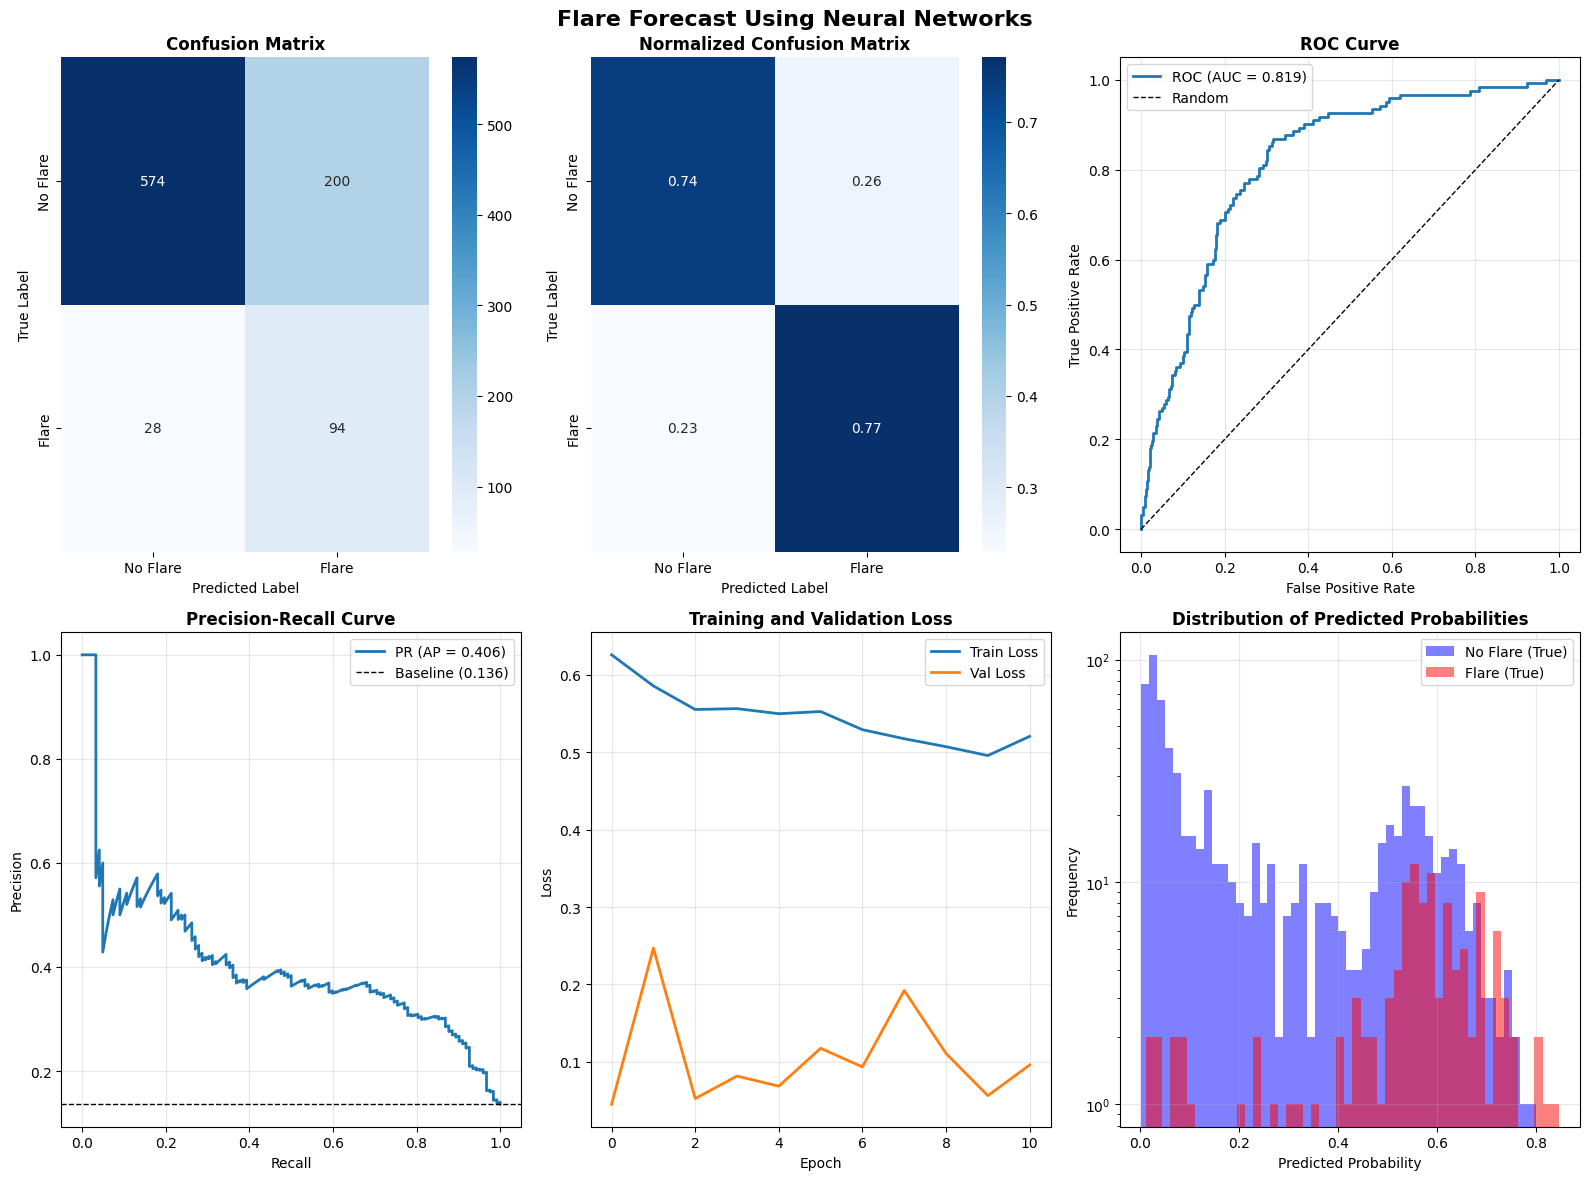

In [27]:
# Visualizations

fig = plt.figure(figsize=(16, 12))
plt.suptitle('Flare Forecast Using Neural Networks', fontsize=16, fontweight='bold')

class_names = ['No Flare', 'Flare']

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=class_names, yticklabels=class_names)
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# 2. Normalized Confusion Matrix
cm_norm = pd.DataFrame(cm).apply(lambda x: x/sum(x), axis = 1)
ax2 = plt.subplot(2, 3, 2)
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues', ax=ax2, xticklabels=class_names, yticklabels=class_names)
ax2.set_title('Normalized Confusion Matrix', fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. ROC Curve
if len(np.unique(y_test)) > 1:
    ax3 = plt.subplot(2, 3, 3)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax3.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('ROC Curve', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Precision-Recall Curve
if len(np.unique(y_test)) > 1:
    ax4 = plt.subplot(2, 3, 4)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax4.plot(recall, precision, linewidth=2, label=f'PR (AP = {avg_precision:.3f})')
    ax4.axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1, 
                label=f'Baseline ({y_test.mean():.3f})')
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Precision')
    ax4.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

# 5. Training and Validation Loss
if 'history' in locals():
    hist = history.history
    ax5 = plt.subplot(2, 3, 5)
    ax5.plot(hist['loss'], label='Train Loss', linewidth=2)
    if 'val_loss' in hist:
        ax5.plot(hist['val_loss'], label='Val Loss', linewidth=2)
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Loss')
    ax5.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

# 6. Prediction Probability Distribution
ax6 = plt.subplot(2, 3, 6)
ax6.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, label='No Flare (True)', color='blue')
ax6.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, label='Flare (True)', color='red')
ax6.set_xlabel('Predicted Probability')
ax6.set_ylabel('Frequency')
ax6.set_yscale('log')
ax6.set_title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/solar_flare_NN_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'solar_flare_NN_results.png'")
plt.show()